In [1]:
import os
import time
import numpy as np
import cv2
import warnings
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras import initializers
from keras.optimizers import Adam
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization, Activation, Conv2D, Conv2DTranspose, LeakyReLU

warnings.simplefilter('ignore')

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
shoes_data = np.load('/content/drive/My Drive/NIKE_vs_ADIDAS-master/shoes.npz')
print(type(shoes_data))

<class 'numpy.lib.npyio.NpzFile'>


In [5]:
print(shoes_data['arr_0'].shape)

(140, 45, 45, 3)


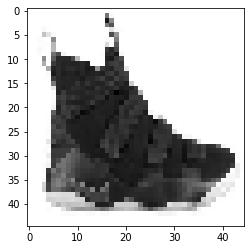

In [6]:
plt.imshow(shoes_data['arr_0'][131, :, :, 0], cmap = 'gray')
plt.show()

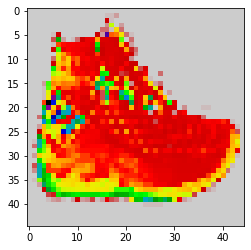

In [7]:
plt.imshow(shoes_data['arr_0'][16, :, :, 0], cmap = 'nipy_spectral')
plt.show()

In [8]:
rows = 45
cols = 45
channels = 3
img_shape = (rows, cols, channels)

z_dim = 100

#using the weight init from Radford et al.
w_init = initializers.RandomNormal(mean = 0.0, stddev = 0.02)

In [9]:
#set the leaky relu slope to 0.2

def Generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(5*5*256, input_dim = z_dim, kernel_initializer = w_init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((5, 5, 256)))

  model.add(Conv2DTranspose(512, kernel_size = 3, strides = 2))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2DTranspose(128, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2DTranspose(3, kernel_size=3, strides=2, activation='tanh'))  #no BN here acc to the implementation
  
  z = Input(shape = (z_dim, ))  #this is the noise
  gen_img = model(z)

  return Model(inputs = z, outputs = gen_img)

In [10]:
# #set the leaky relu slope to 0.2

# def Generator(img_shape, z_dim):
#   model = Sequential()
#   model.add(Dense(5*5*256, input_dim = z_dim, kernel_initializer = w_init))
#   model.add(BatchNormalization())
#   #model.add(LeakyReLU(alpha = 0.2))
#   model.add(Activation('relu'))
#   model.add(Reshape((5, 5, 256)))

#   model.add(Conv2DTranspose(512, kernel_size = 3, strides = 2))
#   model.add(BatchNormalization())
#   #model.add(LeakyReLU(alpha = 0.2))
#   model.add(Activation('relu'))

#   model.add(Conv2DTranspose(128, kernel_size = 3, strides = 2, padding = 'same'))
#   model.add(BatchNormalization())
#   #model.add(LeakyReLU(alpha = 0.2))
#   model.add(Activation('relu'))

#   model.add(Conv2DTranspose(3, kernel_size=3, strides=2))  #no BN here acc to the implementation
#   model.add(Activation('sigmoid'))
  
#   z = Input(shape = (z_dim, ))  #this is the noise
#   gen_img = model(z)

#   return Model(inputs = z, outputs = gen_img)

In [11]:
def Discriminator(img_shape):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = img_shape, kernel_initializer=w_init))
  model.add(LeakyReLU(alpha = 0.2)) #no BN at this stage acc to the implementation

  model.add(Conv2D(64, kernel_size=3, strides = 2))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(96, kernel_size=3, strides = 1))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))  

  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))

  img = Input(shape = img_shape)
  pred = model(img)

  return Model(inputs = img, outputs = pred)


In [12]:
discriminator = Discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

#here we set beta1, the momentum parameter to .5 to avoid oscillation and a stable learning process
generator = Generator(img_shape, z_dim)
z = Input(shape = (100, ))
gen_img = generator(z)

discriminator.trainable = False
pred = discriminator(gen_img)

GAN = Model(inputs = z, outputs = pred)
GAN.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.0002, beta_1 = 0.5))

In [13]:
loss = []
accuracy = []


def train_gan(iterations, batch_size, sampling_interval):

  X_train = shoes_data['arr_0']

  #SCALE THE DATA TO HYPERBOLIC TAN RANGE OF [-1, 1]
  X_train = (X_train.astype('float32') / 127.5) - 1.0
  label_fake = np.zeros((batch_size, 1))
  label_real = np.ones((batch_size, 1))


  for i in range(iterations):
    #produce a random set of ints of batch size to index the train data
    batch_indices = np.random.randint(0, X_train.shape[0], batch_size)
    images_real = X_train[batch_indices] 

    #corr to the above, we also need fake imgs, hence start from noise
    noise = np.random.normal(0, 1, (batch_size, 100))  #each img of noise has a z_dim of 100
    images_fake = generator.predict(noise)

    #D loss is calculated
    D_loss_real = discriminator.train_on_batch(images_real, label_real)
    D_loss_fake = discriminator.train_on_batch(images_fake, label_fake)
    D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)
    #this holds data of loss at index 0 and holds data of accuracy at index 1

    # produce a new crop of fake images based on random noise
    noise = np.random.normal(0, 1, (batch_size, 100))
    images_fake = generator.predict(noise)

    #training the gan = training the generatorm hence train it with real labels
    #backprop thru gan will update only G as the D is frozen
    G_loss = GAN.train_on_batch(noise, label_real)

    if i % sampling_interval == 0:
     
      print('--> %d [Disc loss: %f Accuracy: %.2f%%] [Gen loss: %f]' % (i, D_loss[0], 100*D_loss[1], G_loss))
      loss.append((D_loss[0], G_loss))
      accuracy.append(100*D_loss[1])
      sample_images(i)
  

In [14]:
#plot the images being generated

def sample_images(iteration, rows = 4, cols = 4):
  noise = np.random.normal(0, 1, (rows * cols, z_dim))
  images_fake = generator.predict(noise)

  #rescale images back to the plotting range as tanh gives -1 to 1
  images_fake = images_fake * 0.5 + 0.5
  f, ax = plt.subplots(rows, cols, figsize = (4, 4), sharex = True, sharey = True)
  c = 0

  for i in range(rows):
    for j in range(cols):
      ax[i, j].imshow(images_fake[c, :, :, 0], cmap = 'gray') #gray scale is plotted
      c += 1

--> 0 [Disc loss: 0.672742 Accuracy: 49.61%] [Gen loss: 0.479260]
--> 1000 [Disc loss: 0.496333 Accuracy: 81.25%] [Gen loss: 1.122604]
--> 2000 [Disc loss: 0.310081 Accuracy: 97.66%] [Gen loss: 1.966729]
--> 3000 [Disc loss: 0.479873 Accuracy: 85.16%] [Gen loss: 1.623228]
--> 4000 [Disc loss: 0.329378 Accuracy: 94.92%] [Gen loss: 2.663206]
--> 5000 [Disc loss: 0.317729 Accuracy: 94.14%] [Gen loss: 2.631308]
--> 6000 [Disc loss: 0.068110 Accuracy: 100.00%] [Gen loss: 0.767872]
--> 7000 [Disc loss: 0.083488 Accuracy: 99.61%] [Gen loss: 0.623466]
--> 8000 [Disc loss: 0.027153 Accuracy: 100.00%] [Gen loss: 2.156323]
--> 9000 [Disc loss: 0.052285 Accuracy: 99.61%] [Gen loss: 3.554436]
Completed training in 1182.8212459087372 seconds


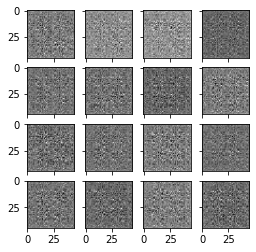

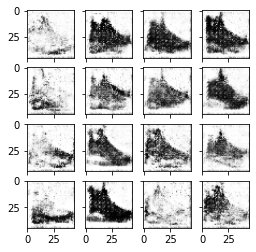

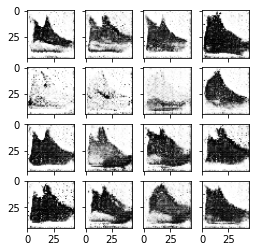

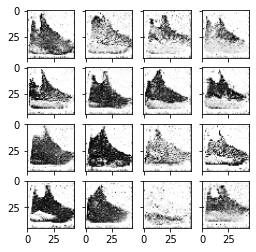

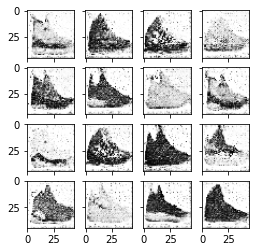

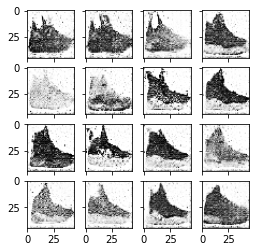

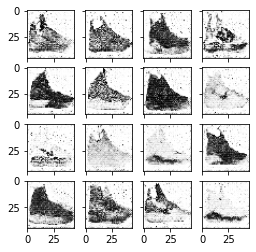

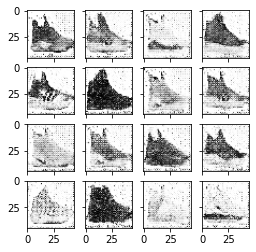

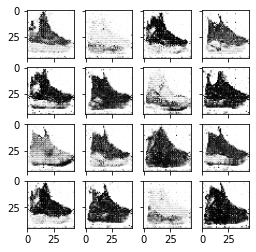

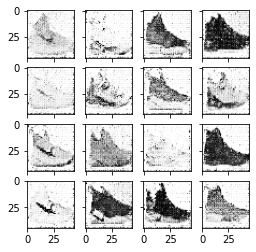

In [15]:
iterations = 10000
sampling_interval = 1000
batch_size = 128

start = time.time()
train_gan(iterations, batch_size, sampling_interval)
print('Completed training in {} seconds'.format(time.time() - start))

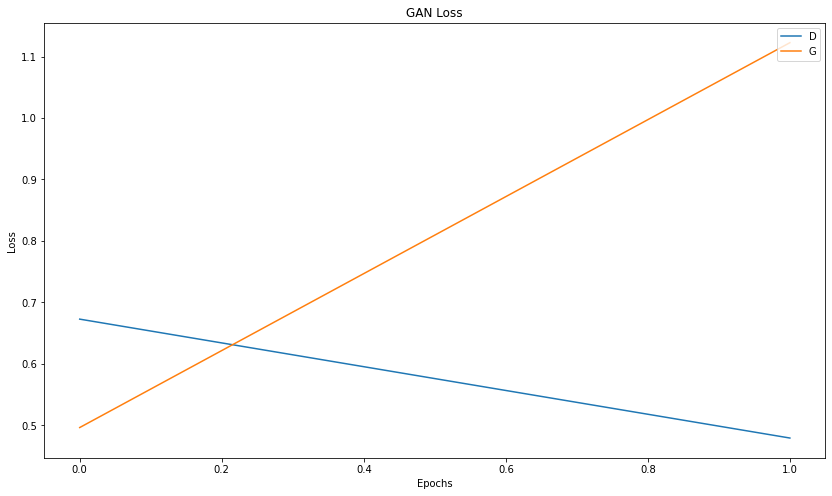

In [19]:
plt.figure(figsize = (14, 8))
plt.plot(loss[0])
plt.plot(loss[1])
plt.title('GAN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['D', 'G'], loc = 'upper right')
plt.show()

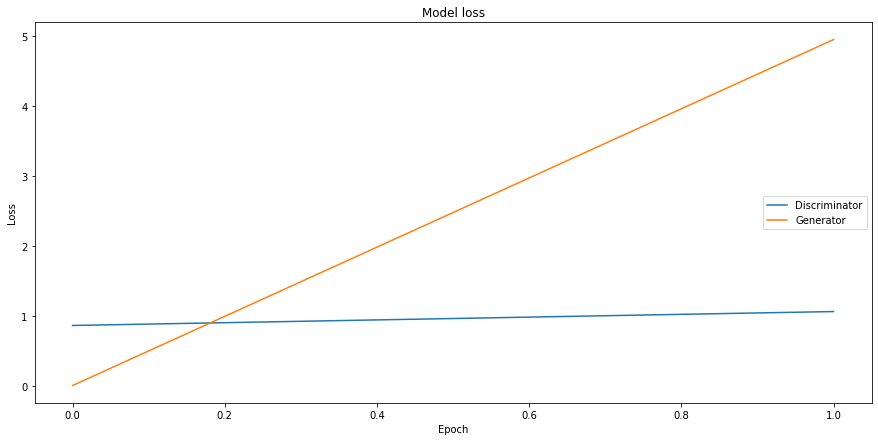

In [23]:
# plot the loss and accuracy metrics
plt.figure(figsize=(15, 7))
plt.plot(loss[0])
plt.plot(loss[1])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()